# Recreating Figures from Rao et al 2009

The paper I am attempting to reacreate to get used to working with the data is from 
https://www.sciencedirect.com/science/article/pii/S0967063709002003

What to create first:
- Monthly Climatology sla
- 10 day negative (upwelling) intervals from Jan 5 - April 25
- 10 day positive (downwelling) intervals from April 25 - 13 Aug

Some things to work on after - look at the climatology for the months 

Climatolgy caluclations use this toolbox : https://cds.climate.copernicus.eu/toolbox/doc/how-to/13_how_to_calculate_climatologies_and_anomalies/13_how_to_calculate_climatologies_and_anomalies.html

Hovmoller plot: https://unidata.github.io/python-gallery/examples/Hovmoller_Diagram.html

## TODO

-Add in a section using sst in boxes to get the IOD index from the OISST.


## Load and Subset SLA Data

In [1]:
# Packages -----------------------------------------------#

# Data Analysis
import xarray as xr
import numpy as np
import pandas as pd

# Plotting
import cartopy.crs as ccrs
from cartopy.feature import LAND
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

# Timing Processes
import time

# make sure the figures plot inline rather than at the end
%matplotlib inline

# Get Data ----------------------------------------------#

# get data from tigress - currently this is Liao's
path = '/home/jennap/projects/LRGROUP/shared_data/ssh_AVISO/'
infn = 'all_adt_sla_global_twosat_phy_l4_vDT2018_daily_1994_2018.nc'

ds = xr.open_dataset(path + infn)
#print(ds.keys())

# Subset ------------------------------------------------#

# Create slice variables to subset domain before finding means
lat_slice = slice(-20, 30) # bounds inclusive
lon_slice = slice(30, 120) # bounds inclusive

# Get data, selecting lat/lon slice
sla = ds['sla'].sel(latitude=lat_slice,longitude=lon_slice)
lat = sla.latitude.values
lon = sla.longitude.values

# Create Grid -------------------------------------------#

# convert to a grid
[lon_grid, lat_grid] = np.meshgrid(lon,lat)

In [2]:
# plot time series of points

stacked = sla.stack(allpoints=['latitude','longitude'])

In [ ]:
for ll in range(stacked.shape[1]):
    timeseries = stacked[:,ll]
    plt.plot(stacked.time,timeseries)
plt.show()

KeyboardInterrupt: 

## Find Climatologies

Note that this block of code can take several minutes (~5-15) to complete depending on how busy the server is.

I used ``cdo ymonmean  all_adt_sla_global_twosat_phy_l4_vDT2018_daily_1994_2018.nc all_adt_sla_global_twosat_phy_l4_vDT2018_monthly_climatology_1994_2018.nc`` and compared it to the figure below to make sure the xarray code was working well. There didn't seem to be a difference at all. This seems to be a more robust way of calculating all climatologies, where the cdo cannot do yearly as far as I know which I need for the interannual. I followed [this link](http://xarray.pydata.org/en/stable/examples/monthly-means.html) for guidance on calculating the climatologies.

In [3]:
start = time.time()

# daily
sla_day_clim = sla.groupby('time.day').mean('time')    

# monthly
sla_mon_clim = sla.groupby('time.month').mean('time') 

# unweighted seasonal
sla_seas_clim_uw = sla.groupby('time.season').mean('time')

# yearly
sla_year_clim = sla.groupby('time.year').mean('time')

# weighted seasonal
month_length = sla.time.dt.days_in_month

# calculate the weights by grouping by 'time.season'.
weights = month_length.groupby('time.season') / month_length.groupby('time.season').sum()

# test that the sum of the weights for each season is 1.0
# will toss an assertion error if they aren't, nothing if they do add to 1
np.testing.assert_allclose(weights.groupby('time.season').sum().values, np.ones(4))

# calculate the weighted average
sla_seas_clim = (sla * weights).groupby('time.season').sum(dim='time')   

# set the places that are now zero from the weights to nans
sla_seas_clim = sla_seas_clim.where(sla_seas_clim != 0,np.nan) # for some reason .where sets the locations not in the condition to nan by default

end = time.time()
print("Elapsed time:", (end - start) // 60 , ' minutes')  

/home/jennap/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Elapsed time: 6.0  minutes


## Plotting Annual Cycle

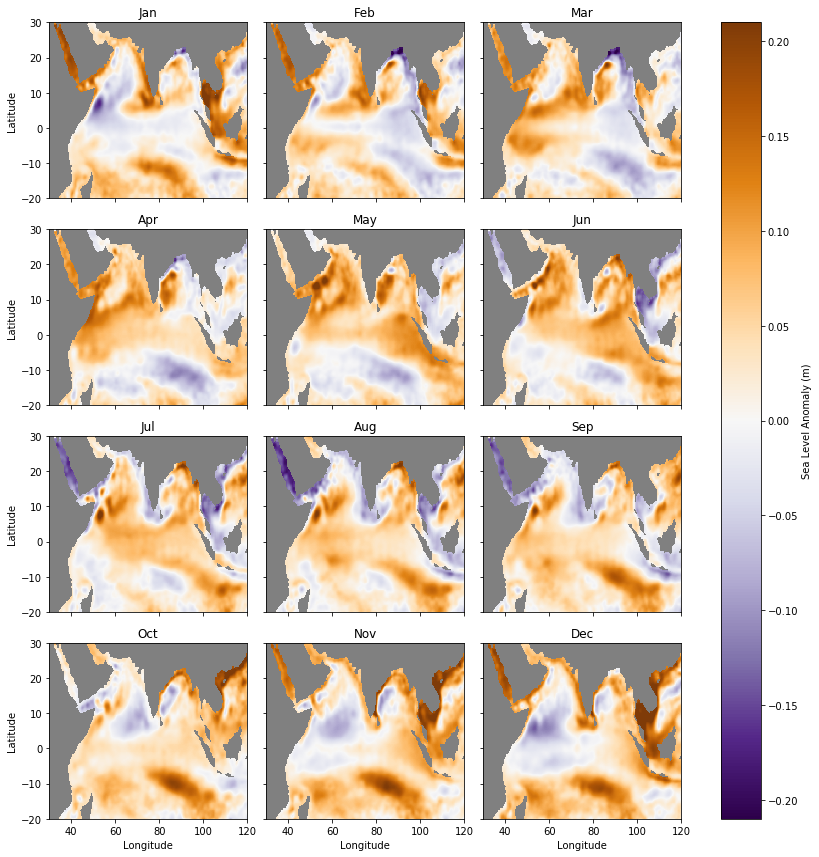

In [4]:
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

p = sla_mon_clim.plot.pcolormesh(x="longitude", y="latitude", col="month", col_wrap=3,
                                        cmap="PuOr_r",
                                        vmax=0.21,vmin=-0.21, # set colorbar lims
                                        extend = 'neither', # make a box colorbar rather than pointed
                                        figsize = (12, 12),
                                        cbar_kwargs={"label": "Sea Level Anomaly (m)"},
                                        subplot_kws={'facecolor': 'gray'}
                                       )

for i, ax in enumerate(p.axes.flat):
    ax.set_title(months[i])
    ax.axes.axis('tight')
#     plt.subplots_adjust(top=.9)

p.set_xlabels('Longitude')
p.set_ylabels('Latitude')

There should be two distinct upwelling/downwelling phases in the annual cycle. Upwelling Kelvin waves, denoted with anomalies, occur in Jan-Mar and then again in Aug-Sep. Downwelling Kelvin waves, denoted with anomalies, occur in Apr-Jun and then again in Oct-Dec

## Plotting Unweighted Seasonal Climatology

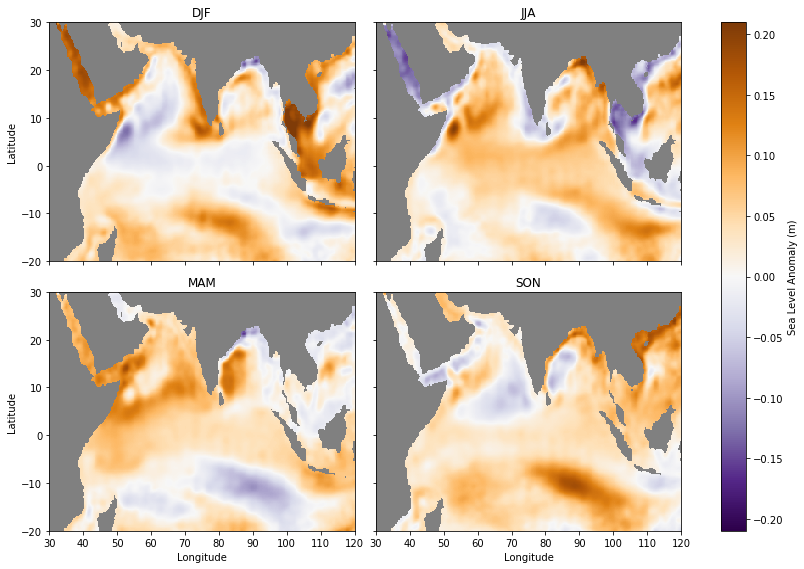

In [5]:
seasons = ['DJF','JJA', 'MAM', 'SON']

p = sla_seas_clim_uw.plot.pcolormesh(x="longitude", y="latitude", col="season", col_wrap=2,
                                        cmap="PuOr_r",
                                        vmax=0.21,vmin=-0.21, # set colorbar lims
                                        extend = 'neither', # make a box colorbar rather than pointed
                                        figsize = (12, 8),
                                        cbar_kwargs={"label": "Sea Level Anomaly (m)"},
                                        subplot_kws={'facecolor': 'gray'}
                                       )

for i, ax in enumerate(p.axes.flat):
    ax.set_title(seasons[i])
    ax.axes.axis('tight')

p.set_xlabels('Longitude')
p.set_ylabels('Latitude')

## Plotting Weighted Seasonal Climatology

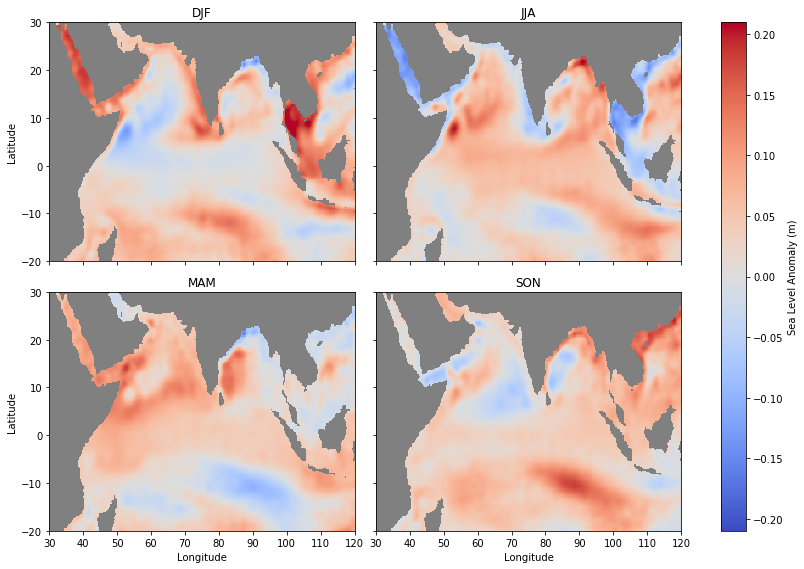

In [5]:
seasons = ['DJF','JJA', 'MAM', 'SON']

p = sla_seas_clim.plot.pcolormesh(x="longitude", y="latitude", col="season", col_wrap=2,
                                        cmap="coolwarm",
                                        vmax=0.21,vmin=-0.21, # set colorbar lims
                                        extend = 'neither', # make a box colorbar rather than pointed
                                        figsize = (12, 8),
                                        cbar_kwargs={"label": "Sea Level Anomaly (m)"},
                                        subplot_kws={'facecolor': 'gray'}
                                       )

for i, ax in enumerate(p.axes.flat):
    ax.set_title(seasons[i])
    ax.axes.axis('tight')

p.set_xlabels('Longitude')
p.set_ylabels('Latitude')

## Plotting Annual Climatology

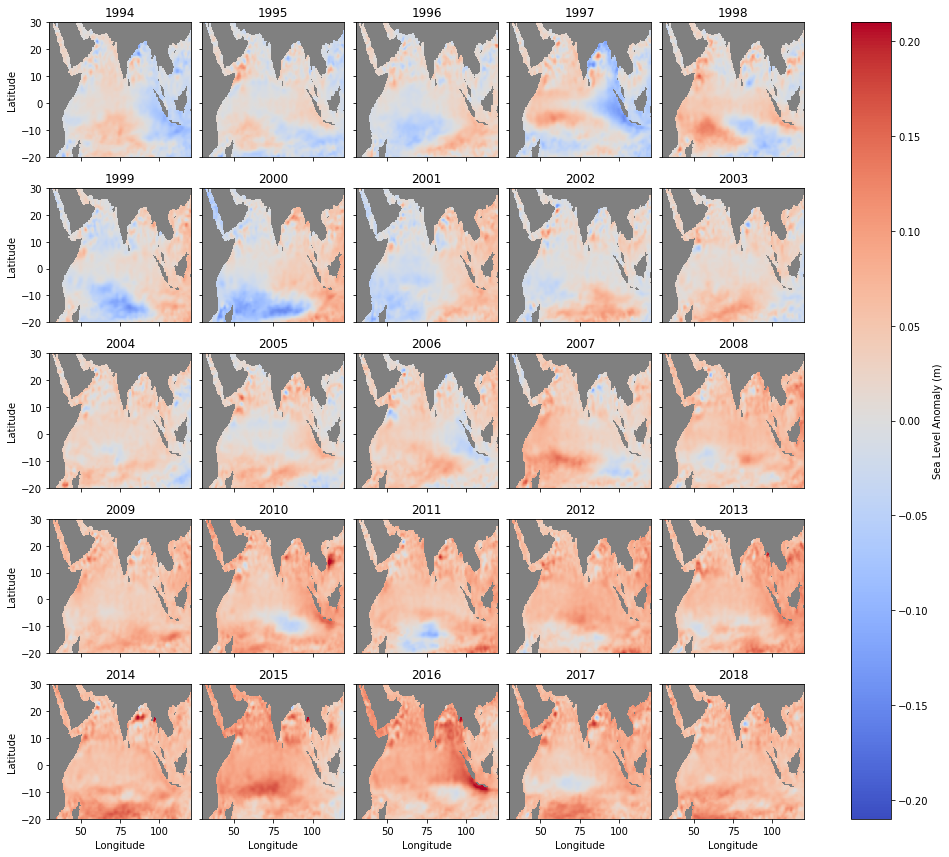

In [6]:
years = list(range(1994,2019))

p = sla_year_clim.plot.pcolormesh(x="longitude", y="latitude", col="year", col_wrap=5,
                                        cmap="coolwarm",
                                        vmax=0.21,vmin=-0.21, # set colorbar lims
                                        extend = 'neither', # make a box colorbar rather than pointed
                                        figsize = (14, 12),
                                        cbar_kwargs={"label": "Sea Level Anomaly (m)"},
                                        subplot_kws={'facecolor': 'gray'}
                                       )

for i, ax in enumerate(p.axes.flat):
    ax.set_title(years[i])
    ax.axes.axis('tight')

p.set_xlabels('Longitude')
p.set_ylabels('Latitude')

## Detrend

In [7]:
# create an example dataset
# sla = xr.DataArray(np.random.rand(10,30,40), dims=['time', 'lat', 'lon'])

# define a function to compute a linear trend of a timeseries
def linear_detrend(y):
    not_nan_ind = ~np.isnan(y)
    m, b, r_val, p_val, std_err = stats.linregress(y.time[not_nan_ind], y[not_nan_ind], 1)
    # we need to return a dataarray or else xarray's groupby won't be happy
    return xr.DataArray(y - (m*x + b))

# stack lat and lon into a single dimension called allpoints
stacked = sla.stack(allpoints=['latitude','longitude'])
# apply the function over allpoints to calculate the trend at each point
detrended_sla = stacked.groupby('allpoints').apply(linear_detrend)
# unstack back to lat lon coordinates
detrended_sla = detrended_sla.unstack('allpoints')
detrended_sla



#         y = sla[:,la,lo]
#         not_nan_ind = ~np.isnan(y)
#         m, b, r_val, p_val, std_err = stats.linregress(time[not_nan_ind],y[not_nan_ind])
#         sla_dtr[:,la,lo] = y - (m*x + b)
    
# plt.plot(x, detrend_y)

TypeError: ufunc add cannot use operands with types dtype('<M8[ns]') and dtype('float64')

In [ ]:
a=np.arange(0.1,10.5)
a

In [ ]:
sla